In [211]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
pd.options.mode.chained_assignment = None # None|'warn'|'raise'

In [144]:
fraud = pd.read_csv('Fraud_Data.csv', parse_dates=['signup_time', 'purchase_time'])
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368.79972,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387.86591,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820.11095,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443.91396,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117.45271,0


In [145]:
ip_addr = pd.read_csv('IpAddress_to_Country.csv')
ip_addr.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.00000,16777471,Australia
1,16777472.00000,16777727,China
2,16777728.00000,16778239,China
3,16778240.00000,16779263,Australia
4,16779264.00000,16781311,China


In [146]:
countries = []
for i in range(len(fraud)):
    ip_address = fraud.loc[i, 'ip_address']
    tmp = ip_addr[(ip_addr['lower_bound_ip_address'] <= ip_address) &
                          (ip_addr['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:
        countries.append(tmp['country'].values[0])
    else:
        countries.append('NA')
        
fraud['country'] = countries

In [147]:
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368.79972,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387.86591,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820.11095,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3840542443.91396,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,415583117.45271,0,United States


# Feature Engineering

Time difference between purchase and sign up for user:
short time might mean fradulent

In [148]:
time_diff = fraud['purchase_time'] - fraud['signup_time']
time_diff = time_diff.apply(lambda x: x.seconds)
fraud['time_diff'] = time_diff

Multiple user id under one devices might be fradulent

In [149]:
device_num = fraud[['user_id', 'device_id']].groupby('device_id').count().reset_index()

In [150]:
device_num = device_num.rename(columns={'user_id': 'device_num'})
device_num

,device_id,device_num
0,AAALBGNHHVMKG,1
1,AAAWIHVCQELTP,1
2,AAAXJHWCLISKY,1
3,AAAXXOZJRZRAO,11
4,AABFGRPBQHWFQ,1
...,...,...
137951,ZZZGSIJRNCXBJ,1
137952,ZZZIKLJSVSQMF,1
137953,ZZZKJIZHJEDFN,1
137954,ZZZMVOGBAJVTM,1


In [151]:
fraud = fraud.merge(device_num, how = 'inner', on = 'device_id')

Multiple user id under one ip_addr might be fradulent

In [152]:
ip_num = fraud[['ip_address', 'device_id']].groupby('device_id').count().reset_index()
ip_num

,device_id,ip_address
0,AAALBGNHHVMKG,1
1,AAAWIHVCQELTP,1
2,AAAXJHWCLISKY,1
3,AAAXXOZJRZRAO,11
4,AABFGRPBQHWFQ,1
...,...,...
137951,ZZZGSIJRNCXBJ,1
137952,ZZZIKLJSVSQMF,1
137953,ZZZKJIZHJEDFN,1
137954,ZZZMVOGBAJVTM,1


In [153]:
ip_num = ip_num.rename(columns={'ip_address': 'ip_num'})

In [154]:
fraud = fraud.merge(ip_num, how = 'inner', on = 'device_id')

In [155]:
fraud

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,device_num,ip_num
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,732758368.79972,0,Japan,13882,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,350311387.86591,0,United States,17944,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820.11095,1,United States,1,12,12
3,48288,2015-01-01 18:52:41,2015-01-01 18:52:42,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820.11095,1,United States,1,12,12
4,128706,2015-01-01 18:52:40,2015-01-01 18:52:41,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2621473820.11095,1,United States,1,12,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,356404,2015-02-04 10:27:49,2015-05-07 19:37:56,41,FXBMCMIOLLNCJ,SEO,Chrome,M,26,1827347950.10364,0,United States,33007,1,1
151108,151643,2015-02-15 20:03:27,2015-05-07 19:28:52,23,THQOCEAVXXAIW,Ads,FireFox,M,18,1691181159.99315,0,United States,84325,1,1
151109,274471,2015-05-15 17:43:29,2015-05-26 12:24:39,35,LYSFABUCPCGBA,SEO,Safari,M,32,2439047221.24922,0,Netherlands,67270,1,1
151110,368416,2015-03-03 23:07:31,2015-05-20 07:07:47,40,MEQHCSJUBRBFE,SEO,IE,F,26,2748470523.70511,0,Japan,28816,1,1


In [156]:
# Parse time to week_num and day_number
fraud['signup_day'] = fraud['signup_time'].apply(lambda x: x.dayofweek)
fraud['signup_week'] = fraud['signup_time'].apply(lambda x: x.week)
fraud['purchase_day'] = fraud['purchase_time'].apply(lambda x: x.dayofweek)
fraud['purchase_week'] = fraud['purchase_time'].apply(lambda x: x.week)

# Model

In [200]:
fraud_copy = fraud[['purchase_value', 'age', 'class', 'time_diff','device_num', 'ip_num',
                   'purchase_day', 'signup_day', 'purchase_week', 'signup_week']]

In [212]:
# Scale numerical data
fraud_copy[['age','purchase_value', 'time_diff', 'device_num', 'ip_num', 
       'signup_day', 'signup_week', 'purchase_day', 'purchase_week']]  = preprocessing.scale(
                                                                                fraud_copy[['age','purchase_value', 'time_diff', 'device_num', 'ip_num', 
                                                                                   'signup_day', 'signup_week', 'purchase_day', 'purchase_week']])
#Creates pseudo-dummy variables for categorical data
#fraud_extend = pd.get_dummies(fraud[['source', 'browser', 'sex', 'country']], prefix=['source', 'browser', 'sex', 'country'])

#fraud_copy = pd.concat([fraud_copy,fraud_extend],axis = 1)

In [213]:
enc = preprocessing.LabelEncoder()
fraud_copy['source'] = enc.fit_transform(fraud['source'])
fraud_copy['country'] = enc.fit_transform(fraud['country'])
fraud_copy['sex'] = enc.fit_transform(fraud['sex'])
fraud_copy['browser'] = enc.fit_transform(fraud['browser'])

In [205]:
X = fraud_copy.loc[:, fraud_copy.columns != 'class']
y = fraud_copy['class']

In [206]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [207]:
rf_model = RandomForestClassifier().fit(X_train,y_train)
rf_pred = rf_model.predict(X_test)

In [208]:
from sklearn.metrics import accuracy_score
print(accuracy_score(rf_pred, y_test))

0.9559002594102388


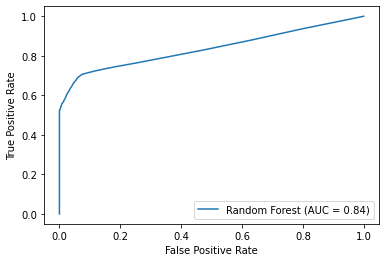

In [209]:
import matplotlib.pyplot as plt 
from sklearn.metrics import plot_roc_curve
disp = plot_roc_curve(rf_model, X_test, y_test,name = "Random Forest")

In [214]:
labels = list(fraud_copy.columns.values)
labels.remove('class')
feat_importance = pd.DataFrame(rf_model.feature_importances_, columns=['values'])
feat_importance['index'] = labels
feat_importance = feat_importance.set_index('index')
feat_importance = feat_importance.sort_values(['values'], ascending=False)
print("Features importance: %s" %feat_importance)

Features importance:                 values
index                 
time_diff      0.22688
purchase_week  0.18516
ip_num         0.12203
device_num     0.11926
signup_week    0.08503
purchase_value 0.06246
age            0.05588
country        0.03863
signup_day     0.03044
purchase_day   0.03038
browser        0.02122
source         0.01275
sex            0.00989


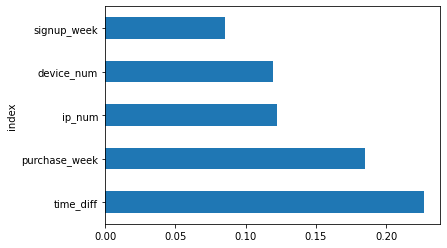

In [218]:
feat_importance['values'].nlargest(5).plot(kind='barh')